In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import os
os.chdir("../")

In [3]:
from policy_functions.policy import Policy
from pandemic_functions.delphi_functions.DELPHI_model_policy_scenarios import *

/Users/saksham/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [4]:
country = "US"
province = "New York"
country_sub = country.replace(' ', '_')
province_sub = province.replace(' ', '_')
# past_parameters = pd.read_csv("pandemic_functions/pandemic_data/Parameters_Global_V2_20200703.csv")
past_parameters = pd.read_csv("pandemic_functions/pandemic_data/NY_Correction_Parameters_Global_V2_annealing_20210409.csv")
totalcases = pd.read_csv(f"pandemic_functions/pandemic_data/Cases_{country_sub}_{province_sub}.csv")

def calculate_gamma_curve(policy):
    parameter_list_total = past_parameters[(past_parameters.Country == country) & (past_parameters.Province == province)]
    final_start_date = max(parse(parameter_list_total['Data Start Date'].values[0]), parse(policy_data_start_date))
    final_start_date = str(final_start_date.date())
    print(final_start_date)

    if country == "US":
        policy_data = read_policy_data_us_only(province, start_date=final_start_date, end_date=policy_data_end_date)
    else:
        policy_data = read_oxford_country_policy_data(start_date=policy.start_date,
                                                end_date=policy.end_date,
                                                country=country)

    if len(parameter_list_total) > 0:
        parameter_list_line = parameter_list_total.iloc[-1, :].values.tolist()
        parameter_list = parameter_list_line[5:]
        date_day_since100 = pd.to_datetime(parameter_list_line[3])
        # Allowing a 5% drift for states with past predictions, starting in the 5th position are the parameters
        start_date = date_day_since100
        validcases = totalcases[
            (totalcases.date >= str(policy.start_date))
            & (totalcases.date <= str(policy.end_date))
        ][["day_since100", "case_cnt", "death_cnt", "total_hospitalization", "people_vaccinated", "people_fully_vaccinated"]].reset_index(drop=True)
    else:
        print(f"Couldn't find past parameters for {country} and {province}")
        return 0, 0, 0, 0

    # Now we start the modeling part:
    if len(validcases) > validcases_threshold_policy:
        PopulationT = popcountries[
            (popcountries.Country == country) & (popcountries.Province == province)
        ].pop2016.iloc[-1]
        N = PopulationT
        PopulationI = validcases.loc[0, "case_cnt"]
        PopulationD = validcases.loc[0, "death_cnt"]
        R_0 = validcases.loc[0, "death_cnt"] * 5 if validcases.loc[0, "case_cnt"] - validcases.loc[0, "death_cnt"]> validcases.loc[0, "death_cnt"] * 5 else 0
        cases_t_14days = totalcases[totalcases.date >= str(start_date- pd.Timedelta(14, 'D'))]['case_cnt'].values[0]
        deaths_t_9days = totalcases[totalcases.date >= str(start_date - pd.Timedelta(9, 'D'))]['death_cnt'].values[0]
        R_upperbound = validcases.loc[0, "case_cnt"] - validcases.loc[0, "death_cnt"]
        R_heuristic = cases_t_14days - deaths_t_9days

        """
        Fixed Parameters based on meta-analysis:
        p_h: Hospitalization Percentage
        RecoverHD: Average Days until Recovery
        VentilationD: Number of Days on Ventilation for Ventilated Patients
        maxT: Maximum # of Days Modeled
        p_d: Percentage of True Cases Detected
        p_v: Percentage of Hospitalized Patients Ventilated,
        balance: Regularization coefficient between cases and deaths
        """
        policy_scenario_end_date = pd.to_datetime(policy.end_date)
        maxT = (policy_scenario_end_date - date_day_since100).days + 1
        policy_scenario_start_date = pd.to_datetime(policy.start_date)
        policy_startT = max((policy_scenario_start_date - date_day_since100).days + 1, 0)
        t_cases = validcases["day_since100"].tolist() - validcases.loc[0, "day_since100"]
        # balance, cases_data_fit, deaths_data_fit, hosp_balance, hosp_data_fit = create_fitting_data_from_validcases(validcases)
        GLOBAL_PARAMS_FIXED = (N, R_upperbound, R_heuristic, R_0, PopulationD, PopulationI, p_v, p_d, p_h)
        best_params = parameter_list
        t_predictions = list(range(maxT))

        print(date_day_since100)
        policy_scenario_gamma_shifts = {}
        for i, alt_policy in enumerate(policy.policy_vector):
            start = policy_scenario_start_date + relativedelta(months=i)
            end = policy_scenario_start_date + relativedelta(months=i+1)

            if start < date_day_since100 and end > date_day_since100:
                start = date_day_since100

            if start >= date_day_since100:
                t1 = (start - date_day_since100).days + 1
                t2 = (end - date_day_since100).days + 1
                latest_policy = get_latest_policy(policy_data, end)
                policy_scenario_gamma_shifts[(t1, t2)] = [
                    default_dict_normalized_policy_gamma[alt_policy],
                    default_dict_normalized_policy_gamma[latest_policy]
                ]
                print((t1, latest_policy, default_dict_normalized_policy_gamma[latest_policy]))

        alpha, days, r_s, r_dth, p_dth, r_dthdecay, k1, k2, jump, t_jump, std_normal  = parameter_list

        def evaluate_gamma(t):
            gamma_t = (
                    (2 / np.pi) * np.arctan(-(t - days) / 20 * r_s) + 1 +
                    jump * np.exp(-(t - t_jump)**2 /(2 * std_normal ** 2))
            )
            
            if t > policy_startT:
                for window, gamma_shifts in policy_scenario_gamma_shifts.items():
                    if t >= window[0] and t<window[1]:
                        normalized_gamma_alt_policy = gamma_shifts[0]
                        normalized_gamma_actual_policy = gamma_shifts[1]
                        gamma_t_month = (
                                (2 / np.pi) * np.arctan(-(window[1] - days) / 20 * r_s) + 1 +
                                jump * np.exp(-(window[1] - t_jump)**2 / (2 * std_normal ** 2))
                        )
                        break               
                epsilon = 1e-4
                gamma_t = gamma_t + min(
                    (2 - gamma_t_month) / (1 - normalized_gamma_alt_policy + epsilon),
                    (gamma_t_month / normalized_gamma_actual_policy) *
                    (normalized_gamma_alt_policy - normalized_gamma_actual_policy)
                )
            return gamma_t

        gamma_curve = [evaluate_gamma(t) for t in t_predictions]
        return gamma_curve

In [5]:
policy1 = Policy(policy_type = "hypothetical", start_date = "2020-03-01", policy_vector = ['Lockdown', 'Lockdown', 'Lockdown'])
gamma1 = calculate_gamma_curve(policy1)

2020-03-08
2020-03-08 00:00:00
(1, 'Lockdown', 0.239)
(25, 'Lockdown', 0.239)
(55, 'Restrict_Mass_Gatherings_and_Schools_and_Others', 0.423)


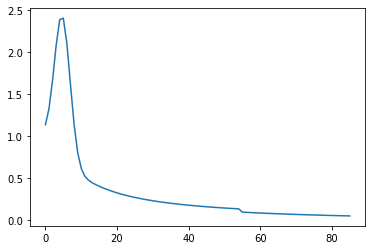

In [6]:
plt.plot(gamma1)

2020-03-08
2020-03-08 00:00:00
(1, 'Lockdown', 0.239)
(25, 'Lockdown', 0.239)
(55, 'Restrict_Mass_Gatherings_and_Schools_and_Others', 0.423)


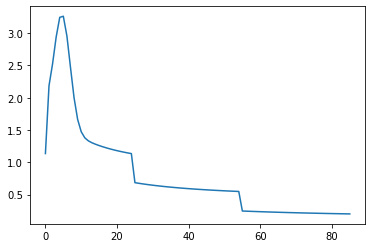

In [7]:
policy2 = Policy(policy_type = "hypothetical", start_date = "2020-03-01", policy_vector = ['No_Measure', 'No_Measure', 'No_Measure'])
gamma2 = calculate_gamma_curve(policy2)
plt.plot(gamma2)

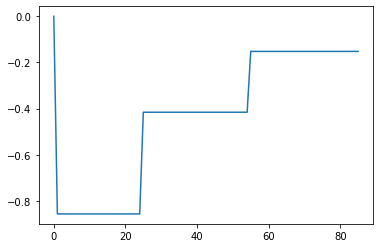

In [13]:
gamma_diff = [(g1-g2) for g1,g2 in zip(gamma1, gamma2)]
plt.plot(gamma_diff)